In [1]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer
from langchain_community.document_loaders.json_loader import JSONLoader
from langchain_community.vectorstores import FAISS
from langchain_community.vectorstores.utils import DistanceStrategy
from langchain_community.embeddings import HuggingFaceEmbeddings
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

e:\repos\arxiv_RAG\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Этап 1. Исследовательский анализ (EDA)

In [2]:
data_path = 'data/nlp_s3_project/'

### Тестовый датасет

In [3]:
df = pd.read_csv(data_path + 'test_sample.csv')

In [4]:
df

,id,abstract,query
0,2412.16732,A new platinate was recently discovered when...,What unique composition and decomposition beha...
1,nucl-th/9602019,The production cross sections of various fra...,How does the inclusion of statistical decay af...
2,2501.05500,This survey provides a comprehensive examina...,What are the core components of modern zero-kn...
3,2506.20892,A critical challenge for operating fusion burn...,How does impurity seeding affect the timing an...
4,2208.02031,"In this work, we present the first corpus fo...",What is the primary challenge of the newly dev...
...,...,...,...
995,2409.18116,We estimate the average of any arithmetic fu...,What are the conditions under which we can est...
996,2311.13142,We focus on a scenario of non-Hermitian bulk...,What new application does the adapted non-Herm...
997,astro-ph/0604183,We carried out a one-night optical V and nea...,What evidence suggests that the near-infrared ...
998,1707.08140,Vertically stacked van der Waals heterostruc...,What effect does processing in an inert gas en...


In [5]:
print(df['abstract'].iloc[0])

  A new platinate was recently discovered when Nd2O3 was explored as a platinum
capture material in the Ostwald process, formed by a direct reaction between
PtO2(g) and Nd2O3. The crystal structure of this new platinate and its
composition, Nd10.67Pt4O24 , are here reported for the first time. The compound
is synthesized either by a direct reaction using PtO2(g) or by the citric acid
chemical route. Based on 3-dimensional electron diffraction data and Rietveld
refinement of high-resolution synchrotron and neutron powder diffraction data,
we accurately describe its crystal structure in space group I41/a. The compound
is structurally related to the Ln11-xSrxIr4O24 (Ln = La, Pr, Nd, Sm) phases
with a double-perovskite (A2BB'O6) like crystal structure and A-site
cation-deficiency. Owing to the fixed oxidation state of Pt(IV), two of the
four Nd-sites are partly occupied to provide charge neutrality, with the Nd4
site taking a split position. On heating, Nd10.67Pt4O24 decomposes into Nd2O3


In [6]:
print(df['query'].iloc[0])

What unique composition and decomposition behavior does the newly discovered platinate Nd10.67Pt4O24 exhibit under thermal conditions?


### Метаданные arxiv, по которым будет производиться поиск

In [7]:
loader = JSONLoader(
    file_path=data_path + 'arxiv-metadata-s.json',
    jq_schema='.[]',
    content_key='abstract'
)
docs = loader.load()

In [8]:
len(docs)

98213

In [9]:
embedder = 'intfloat/multilingual-e5-base'
tokenizer = AutoTokenizer.from_pretrained(embedder)

In [10]:
docs_tokenized = [tokenizer.encode(doc.page_content) for doc in docs]

Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors


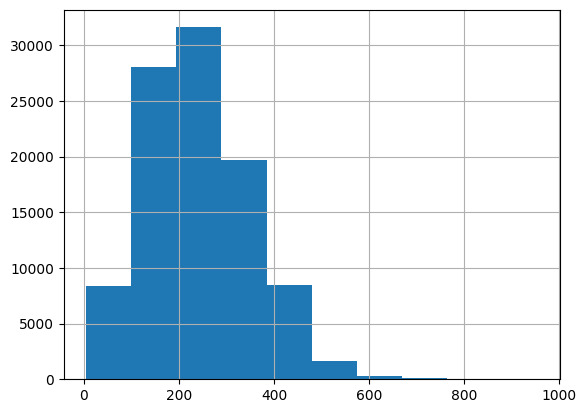

In [11]:
lengths = [len(doc) for doc in docs_tokenized]
fig = pd.Series(lengths).hist()
plt.show()

### Выводы
- Аннотации достаточно короткие - можно обойтись без сплиттера.
- Можно использовать подход к поиску с помощью косинусной близости в FAISS, так как он быстрый, а данные простые и не требуют более сложного подхода (например, графовых БД).
- Эмбеддинговая модель, которую буду использовать: intfloat/multilingual-e5-base - она достаточно легковесная и занимает высокое место в рейтинге mteb. Также можно было бы использовать модель, которая предназначена только для английского языка, т.к. все аннотации в датасете написаны на английском.
- Retrieval-система будет состоять из этапов загрузки документов, создания векторной БД и поиску по запросу в векторной БД. Этап с разделением документов пропущу.

# Этап 2. Реализация retrieval-системы

In [12]:
class RetrievalSystem:
    
    def __init__(self):
        self.embedder_name = 'intfloat/multilingual-e5-base'

        self.tokenizer = AutoTokenizer.from_pretrained(self.embedder_name)
        self.embedding_model = HuggingFaceEmbeddings(
            model_name=self.embedder_name,
            multi_process=True,
            model_kwargs={'device': 'cuda'},
            encode_kwargs={'normalize_embeddings': True}
        )

    def load_documents(self):
        start_time = time.time()
        loader = JSONLoader(
        file_path=data_path + 'arxiv-metadata-s.json',
        jq_schema='.[]',
        content_key='abstract'
        )
        docs = loader.load()

        print("---Документы загружены за %s сек---" % (time.time() - start_time))

        return docs

    def setup_vector_DB(self, docs):
        start_time = time.time()
        embedding_model = HuggingFaceEmbeddings(
        model_name=embedder,
        multi_process=True,
        model_kwargs={'device': 'cuda'},
        encode_kwargs={'normalize_embeddings': True}
        )
        print("---Эмбеддинговая модель загружена за %s сек---" % (time.time() - start_time))


        start_time = time.time()
        self.vector_DB = FAISS.from_documents(
            docs, embedding_model, distance_strategy=DistanceStrategy.COSINE
        )
        print("---Индексная база сформирована за %s сек---" % (time.time() - start_time), 'Размер: ', self.vector_DB.index.ntotal)
    
    def ask(self, query, k=5, verbose=True):
        start_time = time.time()
        retrieved_docs = self.vector_DB.similarity_search(query=query, k=k)
        if verbose:
            print("---Документы найдены за %s сек---" % (time.time() - start_time))

        return retrieved_docs


In [13]:
# Тест работоспособности
# RAG = RetrievalSystem()
# docs = RAG.load_documents()
# RAG.setup_vector_DB(docs)
# retrieved_docs = RAG.ask('test query')

# Этап 3. Оценка качества системы

In [14]:
def evaluate_MRR():
    MRRs = []

    RAG = RetrievalSystem()
    docs = RAG.load_documents()
    RAG.setup_vector_DB(docs)

    for idx, query in tqdm(df['query'].items()):
        relevant_doc = df['abstract'].iloc[idx]

        retrieved_docs = RAG.ask(query, verbose=False)

        for rt_doc in retrieved_docs:
            if rt_doc.page_content == relevant_doc:
    
                relevant_idx = retrieved_docs.index(rt_doc) + 1

                MRR = 1 / relevant_idx

                MRRs.append(MRR)

    return np.mean(MRRs)

In [15]:
MRR = evaluate_MRR()

C:\Users\PM95Y\AppData\Local\Temp\ipykernel_1552\1393693288.py:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  self.embedding_model = HuggingFaceEmbeddings(


---Документы загружены за 11.170516967773438 сек---
---Эмбеддинговая модель загружена за 4.257627010345459 сек---
---Индексная база сформирована за 955.6747937202454 сек--- Размер:  98213


1000it [1:55:20,  6.92s/it]


In [16]:
MRR

np.float64(0.9598579348579348)

### Выводы

- Самые медленные части системы - создание векторной БД и поиск. Для ускорения этих этапов можно взять эмбеддинговую модель поменьше или использовать в FAISS мультипоточность или батчинг.